## Autores: 
Blanco García, Gabriel: gabriel.blanco@cunef.edu   
Ferrín Meilá, Michelle: michelle.ferrin@cunef.edu

# Redes neuroales

<img src='https://www.phdmedia.com/australia/wp-content/uploads/sites/23/2017/11/Ai-banner.jpg' width=4000>

En este notebook se construyen tres redes neuronales básicas, se evalua su rendimiento y se comparan con la regresión logística, eligiendo finalmente un modelo ganador. Para ello, se emplea `Keras` y `Tensorflow`

In [1]:
# Ocultar warnings
import warnings
warnings.filterwarnings("ignore")

# Operaciones báscias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import pickle

# Tensorflow y Keras
import tensorflow as tf
from tensorflow import keras

# Vectorización del texto con Keras
from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence

# Modelos y optimizador Adam
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam

# Distintos tipos de capas de las redes neuronales
from keras.layers import Dense 
from keras.layers import Input 
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling1D 
from keras.layers import Embedding
from keras.layers import LSTM

# Critrerios de parada temprana para las redes
from keras.callbacks import EarlyStopping

# Guardar y cargar modelos de redes neuronales
from keras.models import model_from_json

# Metricas de la logit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# Nuestras funciones
%run ../src/operar_modelos.ipynb
%run ../src/plots_metricas.ipynb

Using TensorFlow backend.


## Importación de los datos

Cargamos como siempre los conjuntos de train y test

In [2]:
X_train = pd.read_pickle('../data/train/X_train.sav')
y_train = pd.read_pickle('../data/train/y_train.sav')

X_test = pd.read_pickle('../data/test/X_test.sav')
y_test = pd.read_pickle('../data/test/y_test.sav')

## Concepto de red neuronal

Las redes neuronales son modelos de Machine Learning que difieren de los clasificadores empleados en el anterior notebook. Su nombre se debe a que su construcción se asemeja ligeramente a la conexión entre las neuronas del cerebro humano. 

El objetivo de las redes es el mismo que el de todos los modelos de clasificación: calcular los pesos o parámetros que acompañan a unas determinadas variables en la modelización de la relación entre una variable dependiente, y unas variables predictoras. En otras palabras, cuánto influye cada predictor en la variable dependiente. Este cálculo se hace minimizando funciones de coste, para lo cual se pueden emplear distintos optimizadores. La diferencia con los clasificadores está en cómo se construyen las redes.

Las redes neuronales se componen de un mínimo de tres capas:

- __Capa input__: por donde recibe los inputs, los datos del problema, las variables, etc.
- __Capa oculta__: es la capa que realiza los diferentes cálculos.
- __Capa output__: la capa con la que el modelo genra los output

Esa es la estructura básica, pero se pueden cosntruir múltiples capas ocultas. Se suele demoniar _Deep Learning_ al uso de aquellas redes que empleen dos o más capas ocultas.

<img src='https://i.redd.it/q3n8ip6bqrq11.png'>

Las capas, a su vez, se componen de neuronas, que son cada una de las unidades encargadas de calcular los pesos. Estas neuronas cuentan con funciones de activación, que son las que emplean en el cáclculo.


El proceso es iterativo, y sigue las siguientes etapas:

1. Cada uno de los inputs entra en la red, y se calculan sus pesos 
2. Se agregan los pesos y se añade una constante, también llamada _bias_ o sesgo
3. La agregación pasa a la función de activación, que genera un ouput
4. Este output pasa a la siguiente capa de la red.
5. Se repite el proceso tantas veces como épocas tenga la red.

<img src='https://qph.fs.quoracdn.net/main-qimg-b019133b165292e51bcbac7b26f0ad61'>



Por tanto, existen múltiples decisiones que hay que tomar, cuyo impacto puede ser crítico en el restultado de la modelización. Algunas de ellas son:

- Número de capas que se emplean.
- Número de neuronas de cada capa.
- Tipo de capas que se emplean.
- Posición de cada capa.
- Función de actvicación de cada capa.
- Optimizador que se emplea.
- Épocas durante las que se va a entrenar la red.
- Criterios de parada temprana: cuando se considera que no merece la pena que la red siga entrenando. 
- Función de coste a minimizar.


Por último, el proceso por el cual se optimizan los pesos de la red neuronal se conoce como _backpropagation_, y consiste en estimar los pesos de manera iterativa a través del último peso, derivadas parciales y descenso del gradiente. No obstante, este último paso no se realiza siempre así. Nosotros utilizaremos el optimizador Adam en lugar del Stochastic Gradient Descent.

## Vectorización

Con redes neuronales y keras, la vectorización y el preparado de los datos cambia ligeramente. Utilizaremos los datos limpios, pero en lugar de usar los vectorizadores y tokenizadores de sklearn, usaremos los de Keras. No obstante, la vectorización es similar, y persigue los mismos objetivos: transformar el texto en vectores, puesto que las redes neuronales tampoco funcionan con texto

Primero, se convierte el texto a frases, utilizando `tokenizer.texts_to_sequences()` sobrec cada conjunto

In [3]:
np.random.seed(1234)

# Inicializamos y ajustamos el tokenizador
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Lo aplicamos a cada tramo
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Es necesario definir el tamaño del vocabulario para las redes
vocab_size = len(tokenizer.word_index) + 1  # se añade 1 para tener un hueco reservado para palabras descononcidas

Después, se vectorizan. Es necesario determinar el máximo número de palabras a considerar para cada vector

In [7]:
# Máxima longitud que consideramos de cada frase
maxlen = 250

X_train = pad_sequences(X_train, 
                        padding='post', # el pad se hace después de cada frase 
                        maxlen=maxlen)

X_test = pad_sequences(X_test, 
                       padding='post', 
                       maxlen=maxlen)

dimensiones_input = X_train.shape[1] # numero de variables, se utilizará en las redes

## Entrenamiento de las redes

Vamos a montar tres redes neuronales, variando la capa segunda capa. Utilizaremos flatten, mgp y lstm. No obstante, hay partes que serán comunes a las tres redes, y que comentaremos a continuación. Estas partes son el _word embedding_, los _criterios de parada temprana_ y las _métricas_.

### Word embeddings

Los word embeddings son una manera de representar los vectores de palabras en un espacio vectoiral. Son un intento de representación geométrica para el lenguaje humano. Se construyen a partir del máximo número de tokens posibles (se calcula en la tokenización) y una serie de parámetros a determinar, que fijan las dimnesiones del embedding. Esta será la primera capa de las tres redes, puesto que es necesaria para pasar de palabras a números.

### Criterios de parada temprana

Como su nombre indica, son criterios que se establecen para limitar el coste computacional. Se establece una regla, basada en una métrica, que determina si la red sigue entrenando o no. En concreto, usaremos la pérdida en test, y 3 épocas como máximo. Si la pérdida en el conjunto de test, durante tres épocas consecutivas, aumenta, se para el entrenamiento, porque se considera que la red ha llegado al tope, y que no merece la pena seguir entrenandola. Usaremos el mismo criterio en las tres redes. El criterio se define a continuación.

In [30]:
# Definimos un criterio de parada temprana
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, # si en 3 epoch no hay bajado el loss, para 
                           verbose=1, 
                           mode='min')

### Métricas

Finalmente, las métricas que se usaran para evaluar las redes serán siempre las mismas, y son el AUC y las tasas de falsos positivos, falsos negativos, verdaderos positivos y verdaderos negativos. Se definen las métricas antes del entrenamiento, para que se vayan calculando para cada época de las redes, aunque solo tendremos en cuenta las de la última época

In [7]:
# Definimos algunas métricas 
# Area bajo la curva roc
auc = tf.keras.metrics.AUC()

# Cada uno de los tipos de clasificacion
# Con estas podremos calcular el coste del modelo y la matriz de confusión
verdaderos_negativos = tf.keras.metrics.TrueNegatives()
falsos_negativos = tf.keras.metrics.FalseNegatives()
verdaderos_positivos = tf.keras.metrics.TruePositives()
falsos_positivos = tf.keras.metrics.FalsePositives()

A continuación construimos y entrenamos las redes

## Red con Flatten

Flatten es una capa básica, que como su nombre indica, "aplana". Su funcionamiento consiste en aplanar la matriz con todos los vectores de los input y sus valores y transformarlos en un array. La primera red utilizará esta capa como segunda capa

In [33]:
embedding_dim = 25 # las dimensiones a las que restringimos el embedding

modelo_flatten = Sequential() # inicio de la red

# La primera capa genera el embedding, con los parámetros ya definidos (común a todas las redes)
modelo_flatten.add(layers.Embedding(input_dim=vocab_size, 
                                    output_dim=embedding_dim, 
                                    input_length=maxlen))

modelo_flatten.add(layers.Flatten()) # añadimos la capa flatten

# La función de activacion ReLU(Rectified Linear Unit) es una función f(x) = max(0, x), es decir, recibe un 
# input, y devuelve como output el máximo entre 0 y ese input
modelo_flatten.add(layers.Dense(10, 
                                activation='relu')) # y dos capas normales, con distinto numero de neuronas.

# La ultima capa utiliza la Sigmoide como función de activación, de la forma ya conocida f(x) = 1 / 1 + e^-x 
modelo_flatten.add(layers.Dense(1, 
                                activation='sigmoid')) 

# Compilamos la red
modelo_flatten.compile(optimizer='adam', # usamos el optimzador adam, que es conocido por ofrecer buenos resultados
                       loss='binary_crossentropy',
                       
                       # Añadimos nuestras métricas
                       metrics=['accuracy',  
                       auc, 
                       verdaderos_negativos, 
                       falsos_negativos,
                       verdaderos_positivos,
                       falsos_positivos])

# Con summary podemo ver el resumen de la red antes de entrenarla
modelo_flatten.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 25)           3775050   
_________________________________________________________________
flatten_6 (Flatten)          (None, 6250)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                62510     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 3,837,571
Trainable params: 3,837,571
Non-trainable params: 0
_________________________________________________________________


Entrenamos la primera red

In [34]:
epochs = 25 # usaremos siempre 25 épocas
batch_size = 10 # es el tamaño de cada muestra 

np.random.seed(1234)
historial_modelo_flatten = modelo_flatten.fit(X_train, y_train, # los conjuntos de entrenamiento
                                             epochs=epochs, # las épocas
                                             verbose=1, # para ver información del proceso
                                             validation_data=(X_test, y_test), # para calcular las métricas
                                             batch_size=batch_size, 
                                             shuffle=False,
                                             callbacks = [early_stop]) # los criterios de parada temprana

Train on 30000 samples, validate on 10000 samples
Epoch 1/25
30000/30000 [==============================] - 166s 6ms/step - loss: 0.3657 - accuracy: 0.8262 - auc_6: 0.8183 - true_negatives_3: 8056.8521 - false_negatives_1: 3116.8916 - true_positives_1: 6462.7866 - false_positives_4: 1648.4657 - val_loss: 0.2909 - val_accuracy: 0.8819 - val_auc_6: 0.9066 - val_true_negatives_3: 16809.4863 - val_false_negatives_1: 4430.8589 - val_true_positives_1: 15106.8838 - val_false_positives_4: 2937.7700
Epoch 2/25
30000/30000 [==============================] - 164s 5ms/step - loss: 0.0681 - accuracy: 0.9758 - auc_6: 0.9407 - true_negatives_3: 26328.1621 - false_negatives_1: 5019.9814 - true_positives_1: 24500.6934 - false_positives_4: 3436.1509 - val_loss: 0.4420 - val_accuracy: 0.8584 - val_auc_6: 0.9585 - val_true_negatives_3: 35978.3516 - val_false_negatives_1: 5561.4590 - val_true_positives_1: 33917.2773 - val_false_positives_4: 3827.8960
Epoch 3/25
30000/30000 [==============================] 

Para poder visualizar el rendimiento de cada red, definimos una función que represente gráficamente la evolución del accuracy y de la pérdida, en train y test, para cada época

In [165]:
def plot_history(historial_red_neuronal):
    '''
    Función para plotear la comparación del accuracy en test y train a lo largo
    de las épocas de la red neuronal
    '''
    
    plt.style.use('ggplot') # Estilo ggplot2
    
    # Acceso a cada una de las métricas del historial, que se dan en forma de diccionario
    accuracy_train = historial_red_neuronal.history['accuracy']
    accuracy_test = historial_red_neuronal.history['val_accuracy']
    loss_train = historial_red_neuronal.history['loss']
    loss_test = historial_red_neuronal.history['val_loss']
    
    # Los datos del eje x
    x = range(1, len(accuracy_train) + 1)

    # Los plots
    plt.figure(figsize=(12, 5))
    # Primer plot: accuracy
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy_train, 'green', label='Accuracy en entrenamiento')
    plt.plot(x, accuracy_test, 'red', label='Accuracy en test')
    plt.title('Accuracy en entrenamiento y test')
    plt.legend() 
    
    # Segundo plot: pérdida
    plt.subplot(1, 2, 2)
    plt.plot(x, loss_train, 'green', label='Pérdida en entrenamiento')
    plt.plot(x, loss_test, 'red', label='Pérdida en test')
    plt.title('Pérdida en entrenamiento y test')
    plt.legend()

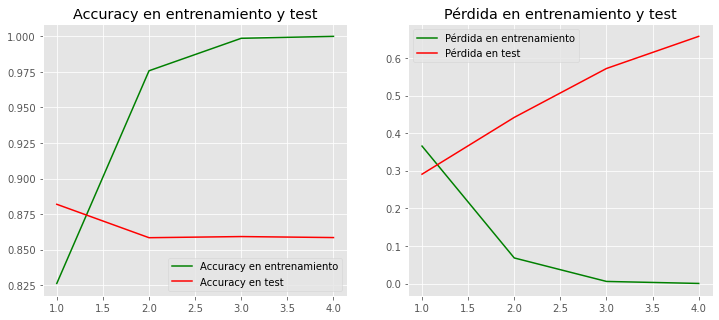

In [166]:
plot_history(historial_modelo_flatten) # se usa la history, no el modelo

Vemosahora la utilidad del criterio de parada temprana. A partir de la época 2, el accuracy se estabiliza y la pérdida se dispara, y no tendría sentido seguir entrenando la red, que ha seguido otras dos épocas. Quizá habría que restringir más aún la parada temprana.

Definimos dos funciones, una para guardar las redes y sus pesos, y otra para cargar la red y los pesos en la misma

In [37]:
def guardar_red_neuronal(red_neuronal, nombre):
    
    # Se guarda la red
    red_neuronal_json = red_neuronal.to_json() # se pasa a json
    ruta_red = f'../models/trained_models/neural_networks/{nombre}.json' # se genera la ruta
    
    # Se guarda la red
    with open(ruta_red, 'w') as json_file:
        json_file.write(red_neuronal_json)
    
    # Se guardan sus pesos en formato h5
    ruta_pesos = f'../models/trained_models/neural_networks/pesos_{nombre}.h5'
    red_neuronal.save_weights(ruta_pesos)
    
    print(f'Red neuronal guardada en {ruta_red}')
    print(f'Pesos guardados en {ruta_pesos}')

In [38]:
def cargar_red_neuronal(nombre_red_neuronal):
    
    # Solo hay que introducir el nombre de la red, porque estaran guardadas en el mismo sitio toddas
    ruta_red = f'../models/trained_models/neural_networks/{nombre_red_neuronal}.json'
    
    # Se carga como json
    json_file = open(ruta_red, 'r')
    modelo_cargado_json = json_file.read()
    json_file.close()
    
    # Se convierte a red dede json
    modelo_cargado = model_from_json(modelo_cargado_json)
    
    # Se cargan sus pesos y se añaden a la red
    ruta_pesos = f'../models/trained_models/neural_networks/pesos_{nombre_red_neuronal}.h5'
    modelo_cargado.load_weights(ruta_pesos)
    
    print('Red neuronal cargada, peso cargados')
    return modelo_cargado

## Red con Global Max Pool 

Esta capa recibe un input n-dimensional y devuelve como output el valor máximo de dicho input. El procedimiento es el mismo, así que no se comenta todo el código, puesto que lo único que varía es la segunda capa.

In [39]:
# La configuración que se utiliza es la misma
embedding_dim = 25

modelo_gmp = Sequential() # inicio de la red

# Capa del embedding
modelo_gmp.add(layers.Embedding(input_dim=vocab_size, 
                                output_dim=embedding_dim, 
                                input_length=maxlen))

# Resto de capas
modelo_gmp.add(layers.GlobalMaxPool1D()) # esta vez usando GlobalMaxPool1d

# Mismas tercera y ultima capa 
modelo_gmp.add(layers.Dense(10, activation='relu'))
modelo_gmp.add(layers.Dense(1, activation='sigmoid'))

# Compilacion de la red
modelo_gmp.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy',  # usamos las mismas métricas
                            auc, 
                            verdaderos_negativos, 
                            falsos_negativos,
                            verdaderos_positivos,
                            falsos_positivos])

# Resumen de la red
modelo_gmp.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 250, 25)           3775050   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                260       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 3,775,321
Trainable params: 3,775,321
Non-trainable params: 0
_________________________________________________________________


In [40]:
np.random.seed(1234)

# Entrenamiento de la red
historial_modelo_gmp = modelo_gmp.fit(X_train, y_train,
                                      epochs=25,
                                      verbose=1,
                                      validation_data=(X_test, y_test),
                                      batch_size=10,
                                      shuffle=False,
                                      callbacks = [early_stop])

Train on 30000 samples, validate on 10000 samples
Epoch 1/25
30000/30000 [==============================] - 180s 6ms/step - loss: 0.4267 - accuracy: 0.8031 - auc_6: 0.9694 - true_negatives_3: 83171.1484 - false_negatives_1: 9694.5645 - true_positives_1: 79649.0703 - false_positives_4: 6770.1807 - val_loss: 0.3278 - val_accuracy: 0.8596 - val_auc_6: 0.9658 - val_true_negatives_3: 91584.4531 - val_false_negatives_1: 11181.6582 - val_true_positives_1: 88120.0938 - val_false_positives_4: 8398.7686
Epoch 2/25
30000/30000 [==============================] - 171s 6ms/step - loss: 0.2668 - accuracy: 0.8885 - auc_6: 0.9644 - true_negatives_3: 100339.2891 - false_negatives_1: 12360.2734 - true_positives_1: 96924.2656 - false_positives_4: 9661.0059 - val_loss: 0.3130 - val_accuracy: 0.8673 - val_auc_6: 0.9635 - val_true_negatives_3: 109212.1328 - val_false_negatives_1: 13467.9863 - val_true_positives_1: 105774.6406 - val_false_positives_4: 10830.0527
Epoch 3/25
30000/30000 [=======================

Hacemos el gráfico para ver el rendimiento

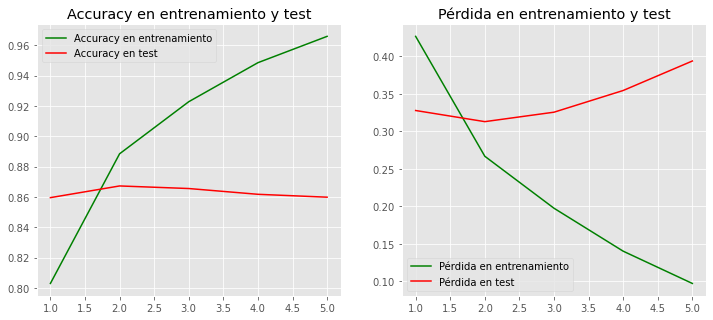

In [167]:
plot_history(historial_modelo_gmp) 

Esta vez la red presenta un accuracy mucho más estable, aunque la pérdida tampoco tardaen dispararse, igual que en el caso con Flatten. Las redes neuronales tienen el inconveniente de sobreajustarse rápidamente.

## Red con LSTM

Finlamente, construimos una red con LSTM como segunda capa.
LSTM (Long Short Term Memory) es un tipo específico de red neuronal recursiva que posee la capacidad de tener "memoria". Se emplean para evitar problemas de dependencia a largo plazo, y para que la red no tenga que comenzar el proceso en cada época como si no supiese nada del problema, como si "no tuviese memoria"

In [42]:
embedding_dim = 25 # misma dimension que siempre

modelo_lstm = Sequential() # inicio

# Capa del embedding
modelo_lstm.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))

modelo_lstm.add(LSTM(32)) # utilizando Long Short-Term Memory con 32 neuronas

# Resto de capas, las de siempre
modelo_lstm.add(layers.Dense(10, activation='relu'))
modelo_lstm.add(layers.Dense(1, activation='sigmoid'))

# Compilacion del modelo
modelo_lstm.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy',  # mismas métricas
                             auc, 
                             verdaderos_negativos, 
                             falsos_negativos,
                             verdaderos_positivos,
                             falsos_positivos])
# Resumen de la red
modelo_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 250, 25)           3775050   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                7424      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 11        
Total params: 3,782,815
Trainable params: 3,782,815
Non-trainable params: 0
_________________________________________________________________


In [43]:
np.random.seed(1234)

# Entrenamiento de la red
historial_modelo_lstm = modelo_lstm.fit(X_train, y_train,
                                        epochs=25,
                                        verbose=1,
                                        validation_data=(X_test, y_test),
                                        batch_size=10,
                                        shuffle=False,
                                        callbacks = [early_stop])

Train on 30000 samples, validate on 10000 samples
Epoch 1/25
30000/30000 [==============================] - 443s 15ms/step - loss: 0.6862 - accuracy: 0.5243 - auc_6: 0.9622 - true_negatives_3: 172148.7656 - false_negatives_1: 23223.2246 - true_positives_1: 165825.1875 - false_positives_4: 18087.3770 - val_loss: 0.6250 - val_accuracy: 0.6640 - val_auc_6: 0.9551 - val_true_negatives_3: 179739.7188 - val_false_negatives_1: 29376.5293 - val_true_positives_1: 169630.0938 - val_false_positives_4: 20538.4395
Epoch 2/25
30000/30000 [==============================] - 435s 14ms/step - loss: 0.6039 - accuracy: 0.6893 - auc_6: 0.9490 - true_negatives_3: 187873.7969 - false_negatives_1: 34117.2305 - true_positives_1: 174872.3281 - false_positives_4: 22421.3965 - val_loss: 0.5563 - val_accuracy: 0.7584 - val_auc_6: 0.9441 - val_true_negatives_3: 196074.1094 - val_false_negatives_1: 37868.3594 - val_true_positives_1: 181079.3438 - val_false_positives_4: 24263.0449
Epoch 3/25
30000/30000 [============

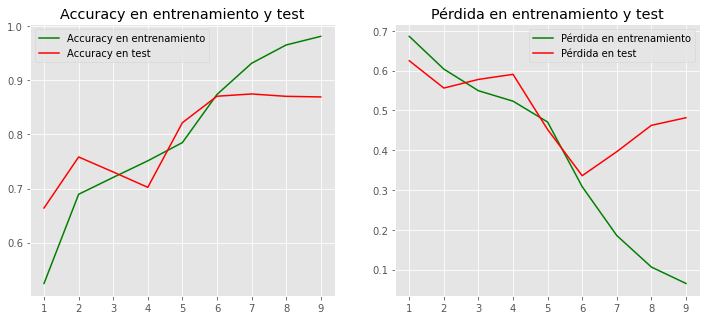

In [168]:
plot_history(historial_modelo_lstm) 

Sin duda, esta red neuronal es la que mejor ha funcionado de todas. Pese a haber estado entreando durante más épocas, los gráficos muestran unos datos relativamente buenos. No hay fuertes subidas de la péridda hasta la sexta épioca, ni caidas abruptas en el accuracy, que va aumentando poco a poco hasta quedarse en torno al 85%, momento en que la péridad emnpieza a subir, y se corta la ejecución

Guardamos las tres redes neuronales y sus pesos antes de continuar, con las funciones que hemos definido,

In [45]:
guardar_red_neuronal(modelo_flatten, 'modelo_flatten')
guardar_red_neuronal(modelo_gmp, 'modelo_gmp')
guardar_red_neuronal(modelo_lstm, 'modelo_lstm')

Red neuronal guardada en ../models/trained_models/neural_networks/modelo_flatten.json
Pesos guardados en ../models/trained_models/neural_networks/pesos_modelo_flatten.h5
Red neuronal guardada en ../models/trained_models/neural_networks/modelo_gmp.json
Pesos guardados en ../models/trained_models/neural_networks/pesos_modelo_gmp.h5
Red neuronal guardada en ../models/trained_models/neural_networks/modelo_lstm.json
Pesos guardados en ../models/trained_models/neural_networks/pesos_modelo_lstm.h5


## Evaluación de las redes y selección del modelo ganador

Utilizando la última época, comparamos las tres redes entre sí, y las comparamos con la regresión logística. Definimos una función que devuelva la tasa de falsos positivos, y el coste unitario del modelo. Utilizamos el coste unitario porque no tenemos claro cuantas veces hace el testeo la red neuronal, pese a que el tramo de test mide exactamente 10.000 observaciones, pero las sumas de los falsos postivios, negativos, etc proporcionan resultados inconsistentes con estas 10.000 observaciones. Comparandolo en términos unitarios, evitamos ese problema. Los costes de cada clasificación son los mismos que se usan con el resto de modelos a lo largo del trabajo.

In [135]:
def evaluacion_red_neuronal(red_neuronal, 
                            coste_verdaderos_negativos=100,
                            coste_verdaderos_positivos=50,
                            coste_falsos_positivos=300,
                            coste_falsos_negativos=80,
                            epoca=-1):
    '''
    La función calcula el coste para la última época por defecto
    '''
    
    # Usando el historial de la red, se extraen las distintas métricas, para la epoca seleccionada
    verdaderos_negativos = red_neuronal.history['val_true_negatives_3'][epoca]
    falsos_positivos = red_neuronal.history['val_false_positives_4'][epoca]
    
    verdaderos_positivos = red_neuronal.history['val_true_positives_1'][epoca]
    falsos_negativos = red_neuronal.history['val_false_negatives_1'][epoca]
    
    # Se calculan las tasas
    tasa_falsos_positivos = falsos_positivos / np.sum([falsos_positivos, verdaderos_negativos]) 
    tasa_verdaderos_negativos = 1 - tasa_falsos_positivos
    
    tasa_verdaderos_positivos = verdaderos_positivos / np.sum([verdaderos_positivos + falsos_negativos])
    tasa_falsos_negativos = 1 - tasa_verdaderos_positivos
    
    # Se calcula el coste 
    coste = np.sum([(-1)*coste_verdaderos_negativos*verdaderos_negativos, # son perdidas que se evitan 
                    coste_falsos_negativos*falsos_negativos,
                    (-1)*coste_verdaderos_positivos*verdaderos_positivos, # son pérdidas que se evitan
                    coste_falsos_positivos*falsos_positivos])
    
    # y el coste unitario
    coste_unitario = coste / np.sum([verdaderos_positivos, verdaderos_negativos, falsos_positivos, falsos_negativos])
    
    # tambien se extrae el accuracy
    accuracy = red_neuronal.history['val_accuracy'][epoca]
    
    # La función devuelve tres outputs, el porcentaje de falsos positivos, el coste unitario y el accuracy
    return round(tasa_falsos_positivos*100, 3), round(coste_unitario, 3), round(accuracy, 3)

Definimos un diccionario con los modelos y sus historiales, y aplicamos la función

In [ ]:
historiales = {
    'modelo_fatten': historial_modelo_flatten, 
    'modelo_gmp': historial_modelo_gmp, 
    'modelo_lstm': historial_modelo_lstm}

In [146]:
for modelo in historiales:
    
    # La función previamente definida devuelve tres ouptuts. La utilizamos sobre cada uno de los 
    # historiales del diccionario, a los cuales se accede con la "key", que es el nombre de cada
    # modelo
    tasa_falsos_positivos, coste_unitario, accuracy = evaluacion_red_neuronal(historiales[modelo])
    
    print(modelo)
    print('Accuracy:', accuracy)
    print('Tasa de falsos positvivos:', tasa_falsos_positivos, '%')
    if (coste < 1):
        print('Ganancia unitaria del modelo', (-1)*coste_unitario, '€') # si el coste es negativo, son ganancias, 
                                                                        # se cambia de signo
                                                        
    else:
        print('Pérdida unitaria del modelo', coste_unitario, '€') 
    print('---------------------------------------')

modelo_fatten
Accuracy: 0.859
Tasa de falsos positvivos: 6.506 %
Ganancia unitaria del modelo 56.276 €
---------------------------------------
modelo_gmp
Accuracy: 0.86
Tasa de falsos positvivos: 8.439 %
Ganancia unitaria del modelo 51.616 €
---------------------------------------
modelo_lstm
Accuracy: 0.869
Tasa de falsos positvivos: 10.602 %
Ganancia unitaria del modelo 41.745 €
---------------------------------------


Cargamos la logit y calculamos sus métricas para compararla con las redes

In [3]:
logit = cargar_modelo('../models/trained_models/classifiers/LogisticRegression().sav')

In [9]:
# Calculamos métricas de la logit para compararla
accuracy_logit = logit.score(X_test, y_test)
y_pred = logit.predict(X_test)
m_confusion = confusion_matrix(y_test, y_pred)
tasa_falsos_positivos = m_confusion[0][1] / np.sum([m_confusion[0][1], m_confusion[0][0]]) 
print('Regresión logística')
print('Accuracy:', round(accuracy_logit, 3))
print('Tasa de falsos positivos:', round(tasa_falsos_positivos, 3)*100, '%')
print('Ganancia unitaria del modelo', (-1)*coste_modelo(logit)/10000, '€') 

Regresión logística
Accuracy: 0.89
Tasa de falsos positivos: 12.3 %
Ganancia unitaria del modelo 44.186 €


La regresión logística tenía un valor total de 441.860 €, que dividido entre las 10.000 observaciones de su test, supone un valor unitario de 44.18 €, un accuracy de 0.89, y una tasa de falsos positivos de aproximadamente el 12%. En este contexto, las dos primeras redes neuronales ofrecen resultados aparentemente más atractivos que la regresión logística. La última de ellas no logra batir el valor económico que genra la logit, aún siendo la red que mejor se ha comportado en términos de accuracy a lo largo de las épocas. Pese a todo esto, __el modelo que finalmente se selecciona es la regresión logística__, por los motivos que se exponen a continuación. 

- __Simpleza__: la regresión logística es un modelo mucho más simple de programar, entrenar, optimizar e interpretar, mientras que las redes neuronales son mucho más opacas, y no es posible comprender a fondo lo que está sucediendo dentro de ellas, ni la influencia de cada combinación de los parámetros. Tampoco es fácil entender cada uno de sus componentes bien, y la falta de experiencia con ellas hace que en ocasiones no se sepa exactamente lo que se está haciendo 
  
  
- __Coste computacional__: el coste que se ha usado para valorar los modelos no ha tenido en cuenta el tiempo de cómputo, ni la capacidad computacional para mantener cada uno de los modelos. En este aspecto, la regresión logística es el modelo más rápido y barato computacionalmente, con diferencia. Las redes neuronales han presentado tiempos de computo prolongados, algo que dificultaría la optimización de sus hiperparámetros.  
  
  
- __Escalabilidad__: en relación con el coste computacional, la regresión logística es escalable de una manera mucho más sencilla. Si la empresa quisiese tener varios modelos logit, por ejemplo uno para cada clúster de clientes, y lanzarlos contra datos masivos, sería mucho más sencillo con la regresión logística. En el caso de uso de este trabajo, se está trabajando con cantidades de 50.000 datos, 30.000 para entrenar. Con estos volúmenes, las redes construidas, pese a no ser demasiado profundas, ya han generado problemas de cómputo. Su puesta en producción con volúmenes mucho más elevados puede disparar los costes de la empresa.  
  
  
- __Overfitting__: si bien es cierto que todas las redes neuronales ofrecen buenos resultados, todas ellas presentan cierto sobreajuste, pasando de accuracys de prácticamente el 100% en entrenamiento a 85% en test. Las redes neuronales tienen el peligro de sobreajustarse con facilidad, algo que reduce su fiabilidad. La regresión logística no ha dado estos problemas.
  
  
- __Costes legales y administrativos__: el reciente endurecimiento del marco regulatorio de los modelos de Machine Learning desalienta el uso de modelos opacos y complejos, puesto que pueden generar problemas a la organización a la hora de no ser capaz de explicar correctamente el modelo a los reguladores. Las multas, calculadas sobre el porcentaje de beneficio de las empresas, salen caras, y un desliz en los modelos puede suponer la quiebra de la compañía. De nuevo, en este aspecto gana la regresión logística, puesto que las probabilidades de infringir la regulación son menores
  
Somos conscientes de que las redes neuronales son poderoas, y tienen potencial, no decimos lo contrario. Pero para este caso de uso, no consideramos que el empleo de redes neuronales merezca la pena, puesto que la ganancia que proporcional no compensa los costes de puesta en funcionamiento y mantenimiento que acarrean. 

En síntesis, el modelo que se selecciona como modelo ganador es la regresión logística, y en el siguiente notebook se optimizan sus hiperparámetros.